# Group
* Daniela Martinez Quiroga
* María Isabella Rodríguez Arévalo

# Installs

# Imports

In [ ]:
# Tensorfolw and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#Ensemble
from sklearn.ensemble import RandomForestClassifier

#SVM
from sklearn.svm import SVC

#Hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Utils for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PCA
from sklearn.decomposition import PCA

#Metrics
from sklearn.metrics import accuracy_score, f1_score

# Data

## Loading and overview

Dimensiones de x_train: (60000, 28, 28)
Dimensiones de y_train: (60000,)


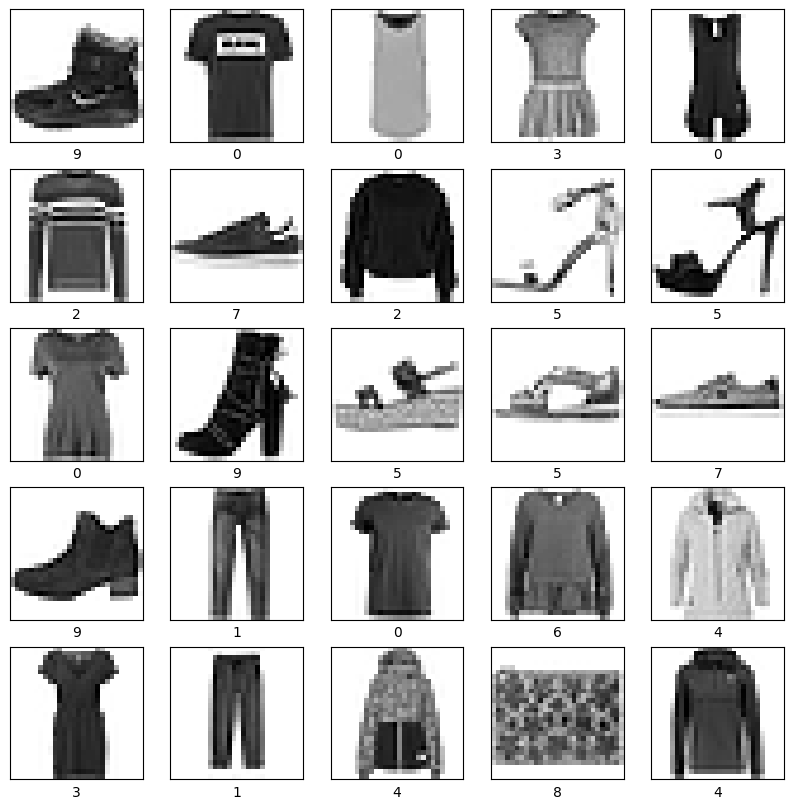

Número de clases: 10
Nombres de las clases: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
# 1. Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# 2. Training data dimensions
print("Dimensiones de x_train:", x_train.shape)
print("Dimensiones de y_train:", y_train.shape)

# 2. See samples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])  # Shows numeric label
plt.show()

# 3. Classes
num_classes = len(np.unique(y_train))
print("Número de clases:", num_classes)

# Classes' names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Nombres de las clases:", class_names)


## Flattering, normalization, missing values
It is discovered that, fortunately, there are no null values.

In [ ]:
# 1. Normalize pixel values:
# Pixel values are originally in the range [0, 255]
# Dividing by 255 scales them to the range [0, 1].
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 2. Flattering
# Converts the 28x28 images into 784-dimensional vectors.
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# Are there any nulls (NaN) ?
print("¿Hay valores NaN en x_train?", np.isnan(x_train).any())
print("¿Hay valores NaN en x_test?", np.isnan(x_test).any())

¿Hay valores NaN en x_train? False
¿Hay valores NaN en x_test? False


# PCA and Components
When analyzing the cumulative explained variance, a relatively small number of principal components is required to retain a high percentage of the total variance. Initially, 784 components were established, but as can be seen in the results:

* For 85% variance: 43 principal components.
* For 90% variance: 84 principal components.
* For 95% variance: 188 principal components.

This means that the dimensionality of the dataset can be reduced without losing much information.

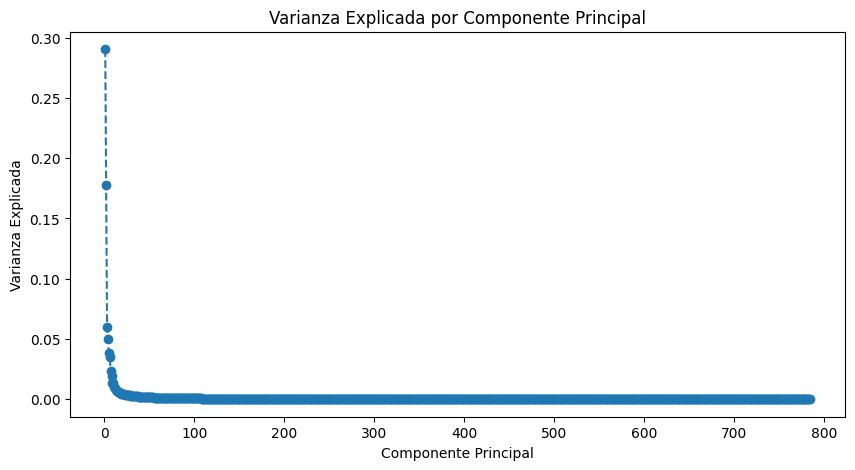

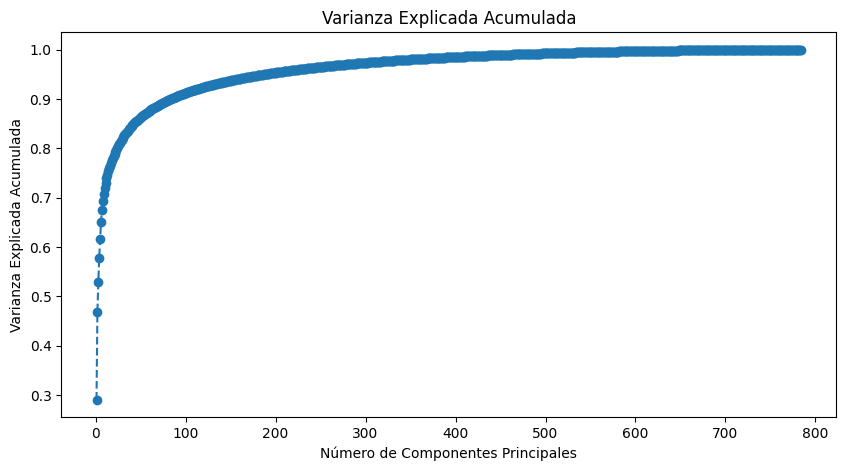

Para retener el 85% de la varianza, se necesitan 43 componentes principales.
Para retener el 90% de la varianza, se necesitan 84 componentes principales.
Para retener el 95% de la varianza, se necesitan 188 componentes principales.


In [ ]:
# 1. Instantiate and fit PCA model
pca = PCA(n_components=784)
pca.fit(x_train)

# 2. Explained variance
explained_variance_ratio = pca.explained_variance_ratio_

# Graph of the variance explained by each component
plt.figure(figsize=(10, 5))
plt.plot(range(1, 785), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Varianza Explicada por Componente Principal')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.show()

# Graph of the cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 5))
plt.plot(range(1, 785), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.show()

# 3. Selección del número de componentes
for desired_variance in [0.85, 0.90, 0.95]:
    n_components = np.argmax(cumulative_variance_ratio >= desired_variance) + 1
    print(f"Para retener el {desired_variance*100:.0f}% de la varianza, se necesitan {n_components} componentes principales.")

# Visualization and Analysis about Principals components

## Visualization


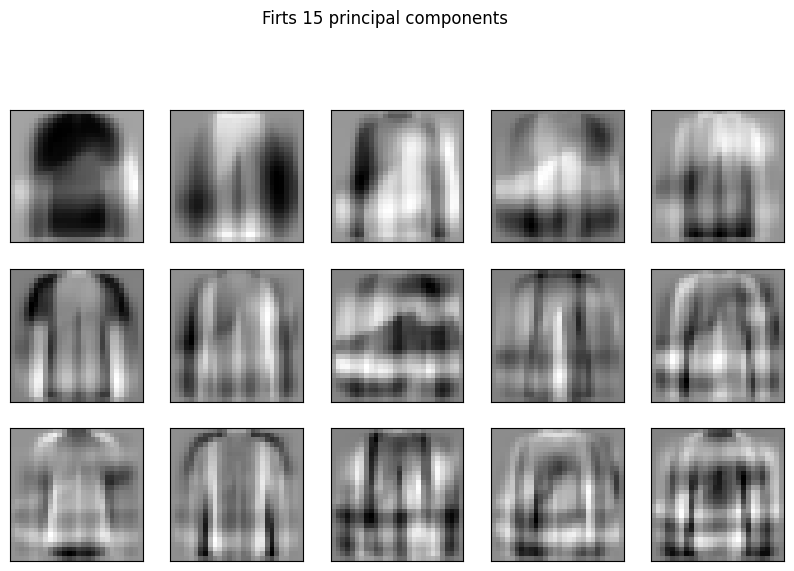

In [ ]:
#Principal components are in components_
components = pca.components_

#Reshape firsts principal components to the original shape
data_reshape = components[:15].reshape(15,28,28)

#Showing these components
plt.figure(figsize=(10, 10))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_reshape[i], cmap=plt.cm.binary)

plt.suptitle('Firts 15 principal components')
plt.show()

### Analysis

These pictures are 15 "eigen-fashions" pictures after making PCA. We can see in each picture has a mix among diferents clothes. For example, in the first one are a shoe and a blouse; in the second one are pants and a blouse; etc. Also in last pictures it's difficult to identify all the clothes. To sum up, each picture are representing different clothes, however in some cases it's hard to recognize the elements in the picture.

## Data projection and 2D Visualization

In this step, the train data will be transformed in a PCA process with components=2

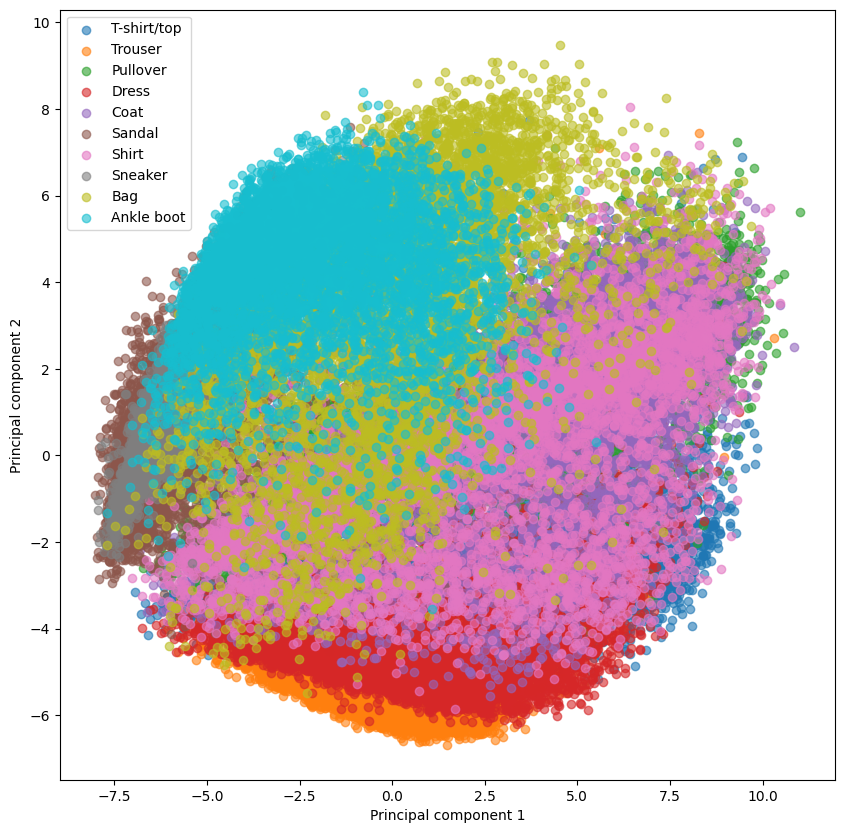

In [ ]:
#Creating PCA
pca_2 = PCA(n_components=2)
pca_2.fit(x_train)

#Transforming the train data
x_train_2d = pca_2.transform(x_train)

#Scatter Plot
plt.figure(figsize=(10, 10))
for i in range(num_classes):
  idx = y_train == i
  plt.scatter(x_train_2d[idx, 0], x_train_2d[idx, 1],
              label=class_names[i],color=plt.cm.tab10(i),alpha=0.6)
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.legend()
plt.show()



### Analysis

In the plot, it is noticed that the components are superimposed. Despite that, there is possible to identify which components are closer than others such as ankle boot or dress. Trouser, sandal and t-shirt are difficult to evalute how closer or dispersed are the data. For that reason, it has to be considered to look for more components in PCA

# Using PCA for modeling



In [ ]:
#PCA models, taking the calculated components before
pca_85 = PCA(n_components=43)
pca_85.fit(x_train)
pca_90 = PCA(n_components=84)
pca_90.fit(x_train)
pca_95 = PCA(n_components=188)
pca_95.fit(x_train)

#Transforming data
x_train_85 = pca_85.transform(x_train)
x_test_85 = pca_85.transform(x_test)

x_train_90 = pca_90.transform(x_train)
x_test_90 = pca_90.transform(x_test)

x_train_95 = pca_95.transform(x_train)
x_test_95 = pca_95.transform(x_test)

## SVM model

In [ ]:
svm_85 = SVC(kernel='rbf', gamma='auto', max_iter=1000)
svm_90 = SVC(kernel='rbf', gamma='auto', max_iter=1000)
svm_95 = SVC(kernel='rbf', gamma='auto', max_iter=1000)

svm_85.fit(x_train_85, y_train)
svm_90.fit(x_train_90, y_train)
svm_95.fit(x_train_95, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(gamma='auto', max_iter=1000)

In [ ]:
y_beanie85_t = svm_85.predict(x_test_85)
y_beanie85_tr = svm_85.predict(x_train_85)
y_beanie90_t = svm_90.predict(x_test_90)
y_beanie90_tr = svm_90.predict(x_train_90)
y_beanie95_t = svm_95.predict(x_test_95)
y_beanie95_tr = svm_95.predict(x_train_95)

accuracy85_t = accuracy_score(y_test, y_beanie85_t)
accuracy85_tr = accuracy_score(y_train, y_beanie85_tr)
accuracy90_t = accuracy_score(y_test, y_beanie90_t)
accuracy90_tr = accuracy_score(y_train, y_beanie90_tr)
accuracy95_t = accuracy_score(y_test, y_beanie95_t)
accuracy95_tr = accuracy_score(y_train, y_beanie95_tr)

f1_score_85_t = f1_score(y_test, y_beanie85_t, average='macro')
f1_score_85_tr = f1_score(y_train, y_beanie85_tr, average='macro')
f1_score_90_t = f1_score(y_test, y_beanie90_t, average='macro')
f1_score_90_tr = f1_score(y_train, y_beanie90_tr, average='macro')
f1_score_95_t = f1_score(y_test, y_beanie95_t, average='macro')
f1_score_95_tr = f1_score(y_train, y_beanie95_tr, average='macro')

# RandomizedForest

In [ ]:
rf_85 = RandomForestClassifier(
    n_estimators=50, max_depth=20,
    min_samples_split=5, min_samples_leaf=2,
    max_features='sqrt', random_state=42
)

rf_90 = RandomForestClassifier(
    n_estimators=50, max_depth=20,
    min_samples_split=5, min_samples_leaf=2,
    max_features='sqrt', random_state=42
)

rf_95 = RandomForestClassifier(
    n_estimators=50, max_depth=20,
    min_samples_split=5, min_samples_leaf=2,
    max_features='sqrt', random_state=42
)

rf_85.fit(x_train_85, y_train)
rf_90.fit(x_train_90, y_train)
rf_95.fit(x_train_95, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, random_state=42)

In [ ]:
y_beanie85_rf_t = rf_85.predict(x_test_85)
y_beanie85_rf_tr = rf_85.predict(x_train_85)
y_beanie90_rf_t = rf_90.predict(x_test_90)
y_beanie90_rf_tr = rf_90.predict(x_train_90)
y_beanie95_rf_t = rf_95.predict(x_test_95)
y_beanie95_rf_tr = rf_95.predict(x_train_95)

accuracy85_rf_t = accuracy_score(y_test, y_beanie85_rf_t)
accuracy85_rf_tr = accuracy_score(y_train, y_beanie85_rf_tr)
accuracy90_rf_t = accuracy_score(y_test, y_beanie90_rf_t)
accuracy90_rf_tr = accuracy_score(y_train, y_beanie90_rf_tr)
accuracy95_rf_t = accuracy_score(y_test, y_beanie95_rf_t)
accuracy95_rf_tr = accuracy_score(y_train, y_beanie95_rf_tr)

f1_score_rf_85_t = f1_score(y_test, y_beanie85_rf_t, average='macro')
f1_score_rf_85_tr = f1_score(y_train, y_beanie85_rf_tr, average='macro')
f1_score_rf_90_t = f1_score(y_test, y_beanie90_rf_t, average='macro')
f1_score_rf_90_tr = f1_score(y_train, y_beanie90_rf_tr, average='macro')
f1_score_rf_95_t = f1_score(y_test, y_beanie95_rf_t, average='macro')
f1_score_rf_95_tr = f1_score(y_train, y_beanie95_rf_tr, average='macro')

# Red Neuronal

In [ ]:
model_85 = Sequential([
    Dense(128, activation='relu', input_shape=(43,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_85.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_90 = Sequential([
    Dense(128, activation='relu', input_shape=(84,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_90.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_95 = Sequential([
    Dense(128, activation='relu', input_shape=(188,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_95.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_85.fit(x_train_85, y_train, epochs=10, validation_split=0.1)
model_90.fit(x_train_90, y_train, epochs=10, batch_size=32, validation_split=0.1)
model_95.fit(x_train_95, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_beanie85_rn_t = model_85.predict(x_test_85)
y_beanie85_rn_tr = model_85.predict(x_train_85)
y_beanie90_rn_t = model_90.predict(x_test_90)
y_beanie90_rn_tr = model_90.predict(x_train_90)
y_beanie95_rn_t = model_95.predict(x_test_95)
y_beanie95_rn_tr = model_95.predict(x_train_95)

loss85_t, accuracy85_rn_t = model_85.evaluate(x_test_85, y_test)
loss90_t, accuracy90_rn_t = model_90.evaluate(x_test_90, y_test)
loss95_t, accuracy95_rn_t = model_95.evaluate(x_test_95, y_test)

loss85_tr, accuracy85_rn_tr = model_85.evaluate(x_train_85, y_train)
loss90_tr, accuracy90_rn_tr = model_90.evaluate(x_train_90, y_train)
loss95_tr, accuracy95_rn_tr = model_95.evaluate(x_train_95, y_train)

f1_score_rn_85_t = f1_score(y_test, y_beanie85_rn_t.argmax(axis=1), average='macro')
f1_score_rn_85_tr = f1_score(y_train, y_beanie85_rn_tr.argmax(axis=1), average='macro')
f1_score_rn_90_t = f1_score(y_test, y_beanie90_rn_t.argmax(axis=1), average='macro')
f1_score_rn_90_tr = f1_score(y_train, y_beanie90_rn_tr.argmax(axis=1), average='macro')
f1_score_rn_95_t = f1_score(y_test, y_beanie95_rn_t.argmax(axis=1), average='macro')
f1_score_rn_95_tr = f1_score(y_train, y_beanie95_rn_tr.argmax(axis=1), average='macro')

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9102 - loss: 0.2392 - val_accuracy: 0.8848 - val_loss: 0.3245
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9119 - loss: 0.2341 - val_accuracy: 0.8798 - val_loss: 0.3268
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9159 - loss: 0.2262 - val_accuracy: 0.8852 - val_loss: 0.3273
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9169 - loss: 0.2228 - val_accuracy: 0.8833 - val_loss: 0.3308
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9178 - loss: 0.2155 - val_accuracy: 0.8838 - val_loss: 0.3453
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9193 - loss: 0.2149 - val_accuracy: 0.8810 - val_loss: 0.3310
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9237 - loss: 0.2021 - val_accuracy: 0.8835 - val_loss: 0.3334
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9259 - loss: 0.1985 - 

# Analysis

In [ ]:
table_tr = {
    "Model": ["SVM", "Random Forest", "Red Neuronal"],
    "Accuracy 85": [accuracy85_tr, accuracy85_rf_tr, accuracy85_rn_tr],
    "Accuracy 90": [accuracy90_tr, accuracy90_rf_tr, accuracy90_rn_tr],
    "Accuracy 95": [accuracy95_tr, accuracy95_rf_tr, accuracy95_rn_tr],
    "F1 Score 85": [f1_score_85_tr, f1_score_rf_85_tr, f1_score_rn_85_tr],
    "F1 Score 90": [f1_score_90_tr, f1_score_rf_90_tr, f1_score_rn_90_tr],
    "F1 Score 95": [f1_score_95_tr, f1_score_rf_95_tr, f1_score_rn_95_tr]
}

table_t = {
    "Model": ["SVM", "Random Forest", "Red Neuronal"],
    "Accuracy 85": [accuracy85_t, accuracy85_rf_t, accuracy85_rn_t],
    "Accuracy 90": [accuracy90_t, accuracy90_rf_t, accuracy90_rn_t],
    "Accuracy 95": [accuracy95_t, accuracy95_rf_t, accuracy95_rn_t],
    "F1 Score 85": [f1_score_85_t, f1_score_rf_85_t, f1_score_rn_85_t],
    "F1 Score 90": [f1_score_90_t, f1_score_rf_90_t, f1_score_rn_95_t],
    "F1 Score 95": [f1_score_95_t, f1_score_rf_95_t, f1_score_rn_95_t]
}

df_tabla_tr = pd.DataFrame(table_tr)
df_tabla_t = pd.DataFrame(table_t)
print(df_tabla_tr)
print(df_tabla_t)

           Model  Accuracy 85  Accuracy 90  Accuracy 95  F1 Score 85  \
0            SVM     0.834450     0.759033     0.724733     0.837596   
1  Random Forest     0.984417     0.987433     0.993000     0.984403   
2   Red Neuronal     0.928183     0.951533     0.976133     0.927924   

   F1 Score 90  F1 Score 95  
0     0.751833     0.706737  
1     0.987427     0.992998  
2     0.951844     0.976160  
           Model  Accuracy 85  Accuracy 90  Accuracy 95  F1 Score 85  \
0            SVM       0.8174       0.7446       0.7130     0.820723   
1  Random Forest       0.8582       0.8530       0.8471     0.856857   
2   Red Neuronal       0.8785       0.8796       0.8826     0.878254   

   F1 Score 90  F1 Score 95  
0     0.737312     0.695847  
1     0.851530     0.844783  
2     0.882995     0.882995  


1. Looking into the final results, the best model is the neuronal network according with the train data and test data. However, the results in test data in all the models got results under 0.9 which isn't perfect or ideal for a model.
2. **TEST DATA SCORES:** The neuronal network has the best results. Also, this was improving in each variance results showing us this could work better with a high variance. On the other hand, SVM and Random forest decrease the accuracy and f1 score results when the variance was high.
3. **TRAIN DATA SCORES:** The random forest has the best results and the scores increse when the variance was high. The same situation happens with neuronal network but this doesn't have the highest score. SVM has the contrary situation, its scores decrease with high variance.
4. We concluded that SVM couldn't work with high variance in its datasets beacuase the accuracy and f1 score got bad numbers. Second, Random Forest depends in other hyperparameters or parameters to increase or decrease its scores beacuse the variances doesn't have the same influence in the data. Finally, neuronal network has a postitve relation with the variance since it has shown its scores improve with more variance.